In [1]:
import os
import sys
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.insert(0, module_path)
    
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
mpl.rcParams['font.family']="WenQuanYi Zen Hei"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import json

In [2]:
from detnet.data import COCODetection

dataset_path = Path('/home/xu/Downloads/object_cxr')

In [4]:
dataset = COCODetection(dataset_path/'train', dataset_path/'train.json')


loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [5]:
print(dataset)
print(dataset.classnames)

COCODetection
  No. of images: 8000
  No. of classes: 1
  No. of bboxes 8223
  Root Location: /home/xu/Downloads/object_cxr/train

['background', 'object']


In [7]:
from detnet.utils.visualization import draw_bbox_on_image, draw_train_sample

In [10]:
from detnet.transforms.train_transforms import ToRGB
dataset = dataset >> ToRGB()

{'image_id': '00008.jpg', 'input': <PIL.Image.Image image mode=RGB size=2752x2829 at 0x7F9A0F23EE50>, 'bbox': array([[0.26526162, 0.60798872, 0.68931687, 0.94485682, 1.        ]])}


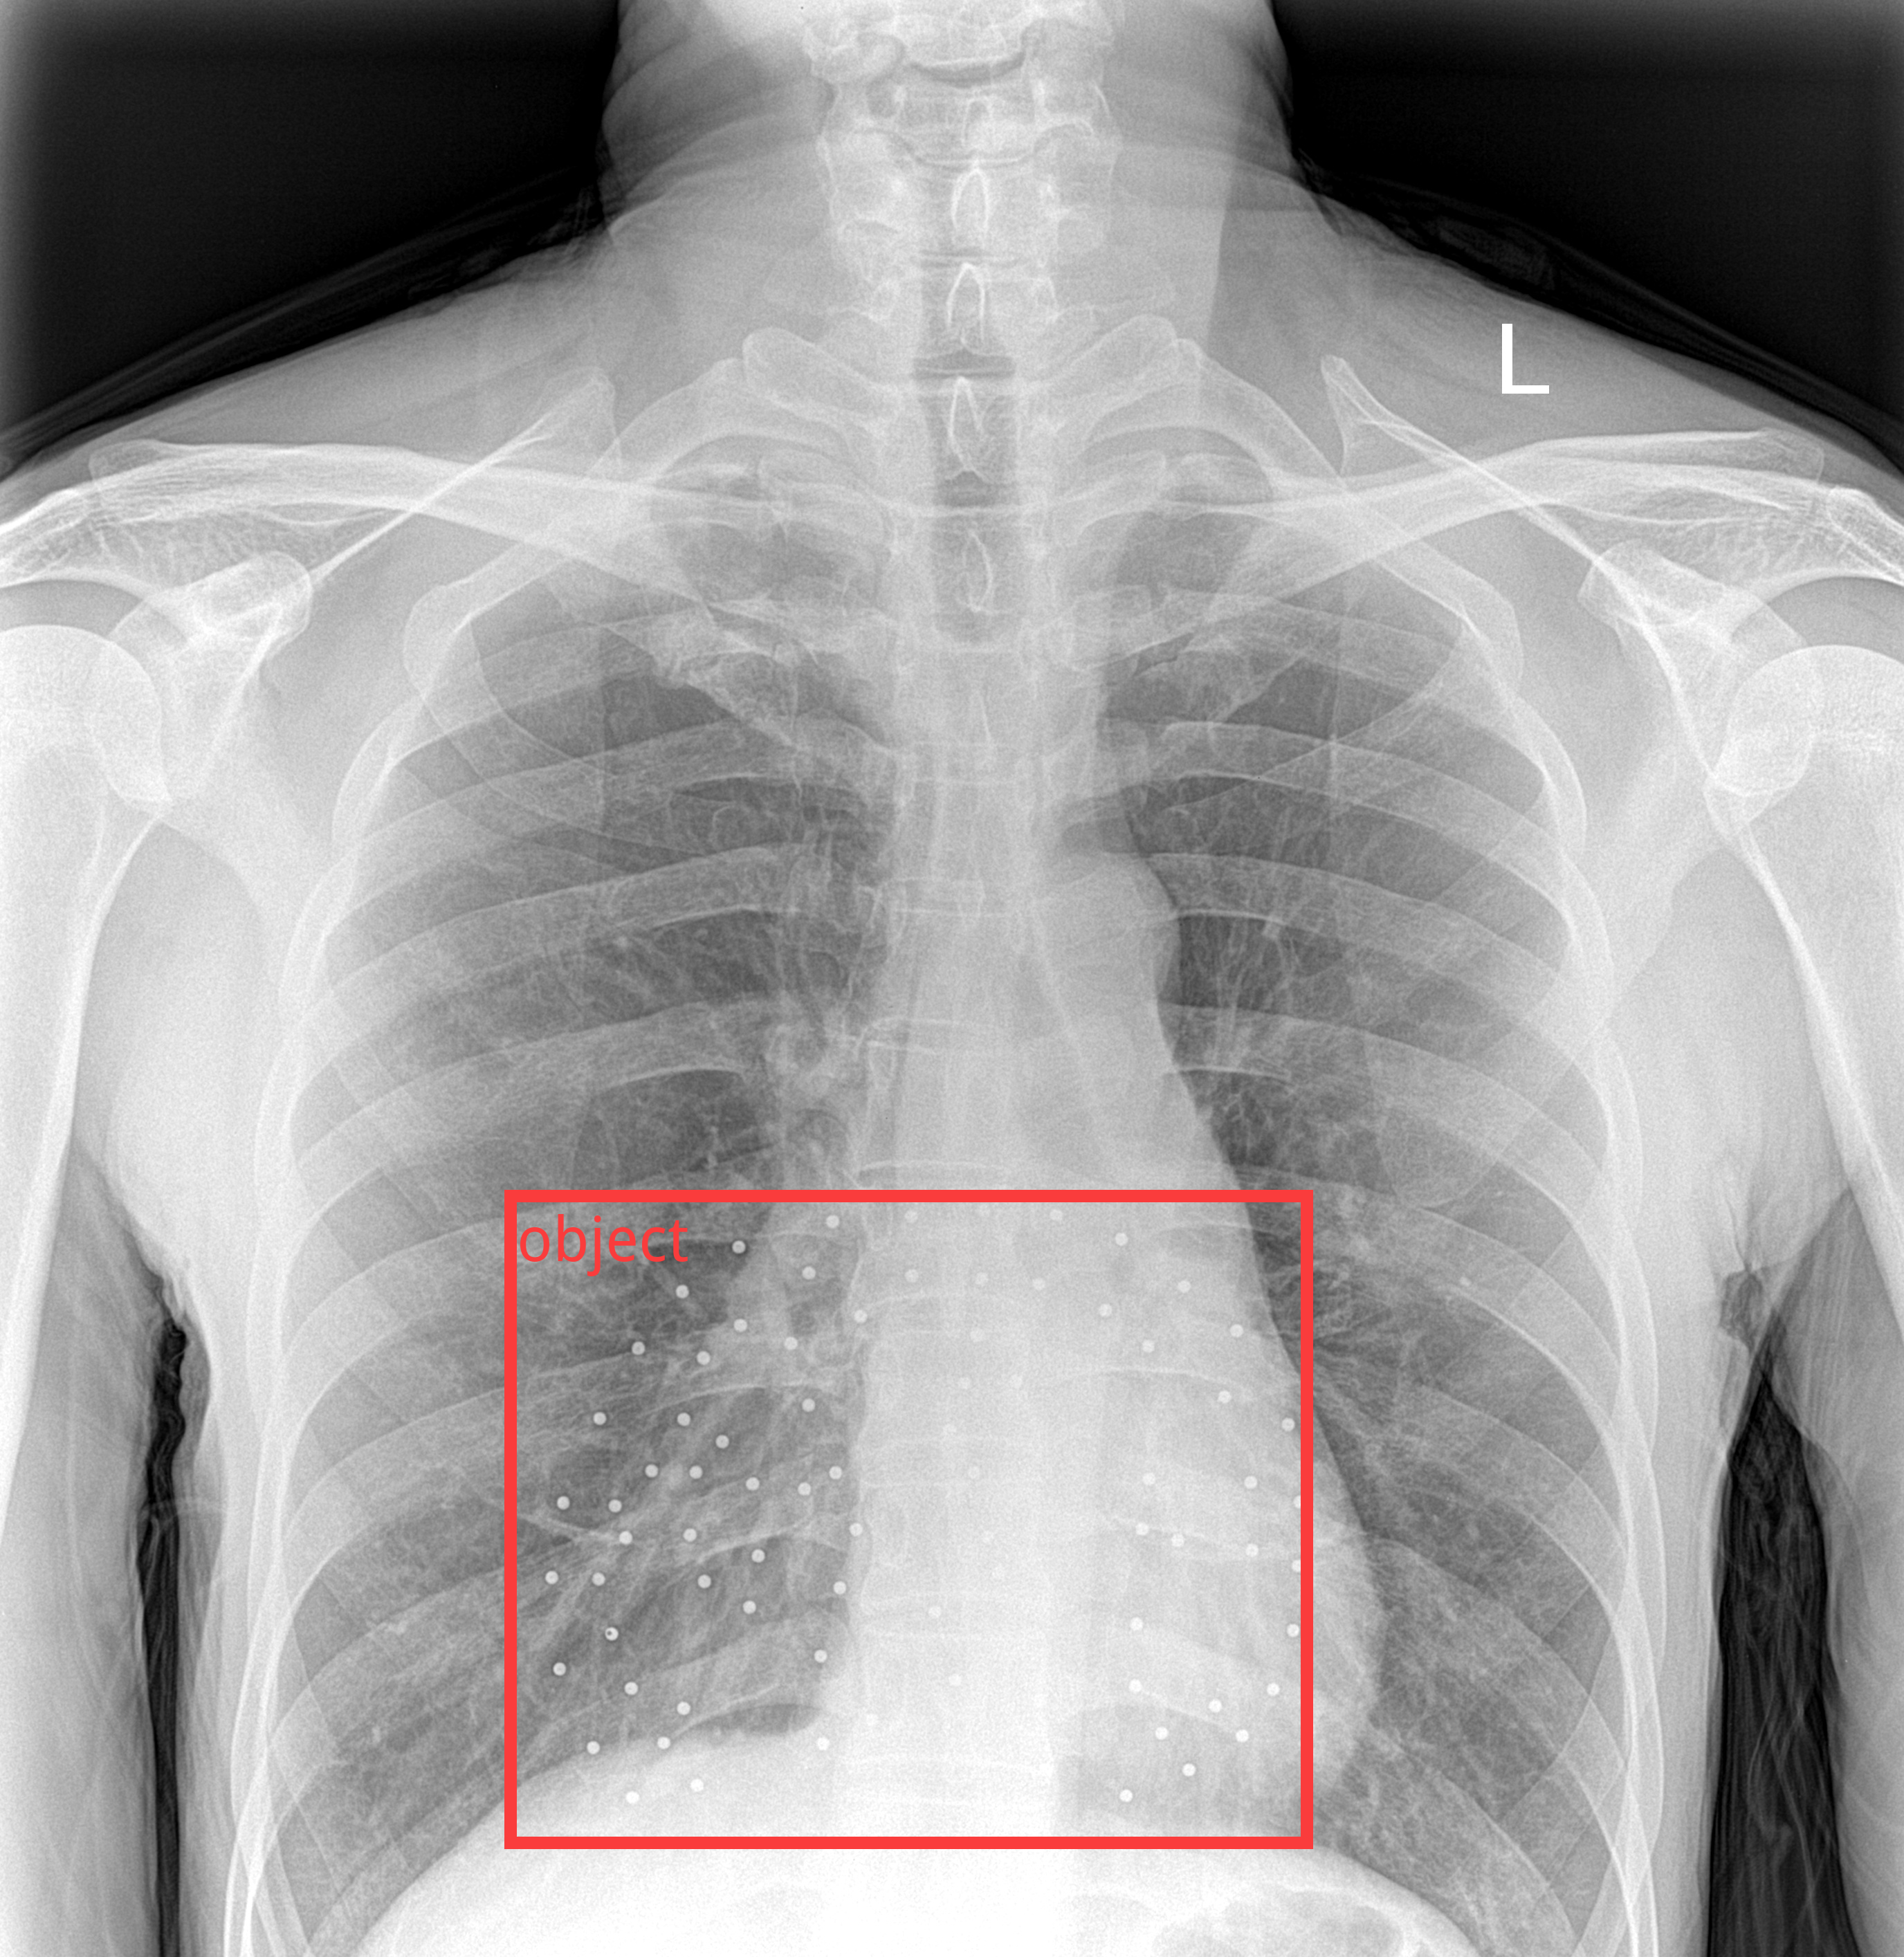

In [13]:
sample = dataset[7]
print(sample)
draw_train_sample(sample, dataset.classnames)

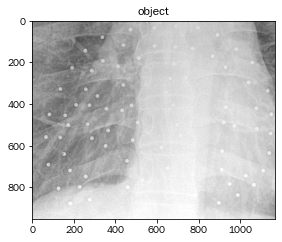

In [14]:
def zoom_show(sample, classnames):
    bboxes = sample['bbox']
    n_box = len(bboxes)
    plt.figure(figsize=(20, 5*n_box))
    image = sample['input']
    width, height = image.width, image.height
    scale = np.asarray([width, height, width, height])
    for i, box in enumerate(bboxes):
        #box = np.clip(box, 0, 1)
        coord = box[:4] * scale
        plt.subplot(n_box, 4, i + 1)
        box_image = image.crop(coord)
        plt.imshow(box_image)
        plt.title(classnames[int(box[4])])
    plt.show()
zoom_show(sample, dataset.classnames)

In [15]:
def find_class(dataset, classname, n=10, return_index=False):
    cls = dataset.classnames.index(classname)
    samples = []
    indices = []
    for i, sample in enumerate(dataset):
        label = sample['bbox'][:, -1].astype(np.int)
        if (label == cls).any():
            samples.append(sample)
            indices.append(i)
            if n > 0 and len(samples) >= n:
                break
    if return_index:
        return indices
    return samples
    

def draw_class(dataset, classname):
    samples = find_class(dataset, classname, 20)

    rows = int(np.ceil(len(samples) / 5))
    f, axarr = plt.subplots(rows, 5, figsize=(25, 5*rows)) 
    for i, sample in enumerate(samples):
        img = draw_train_sample(sample, dataset.classnames)
        axarr.flat[i].imshow(img)
    return samples

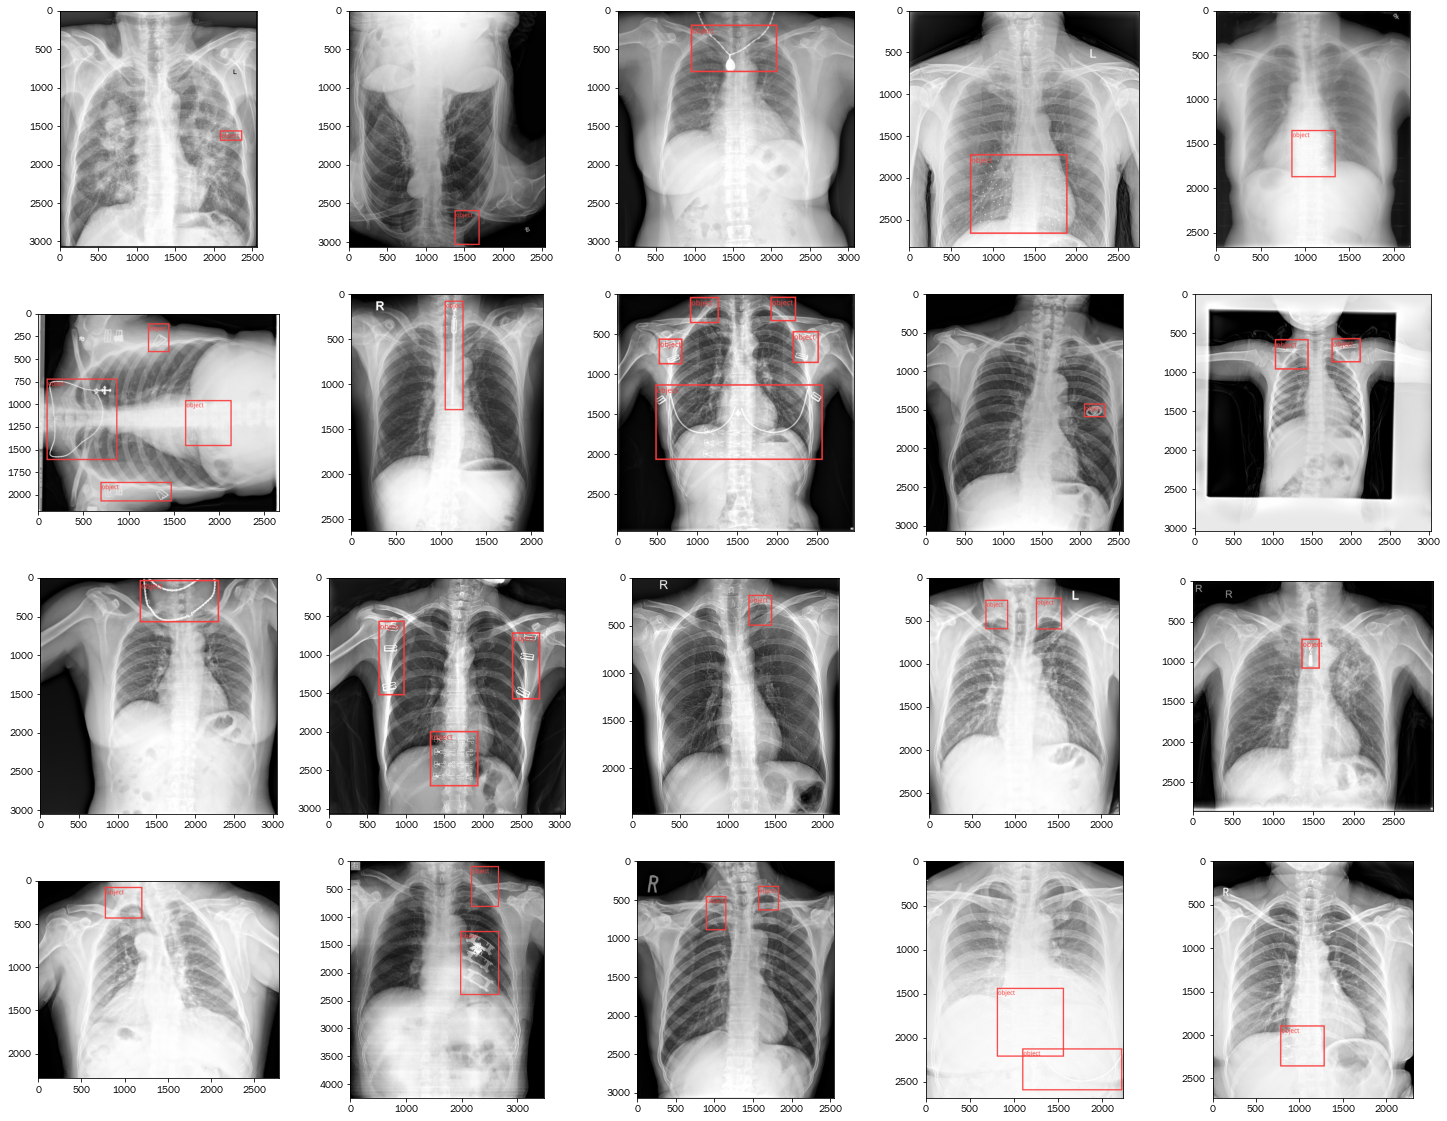

In [16]:
samples = draw_class(dataset, 'object')

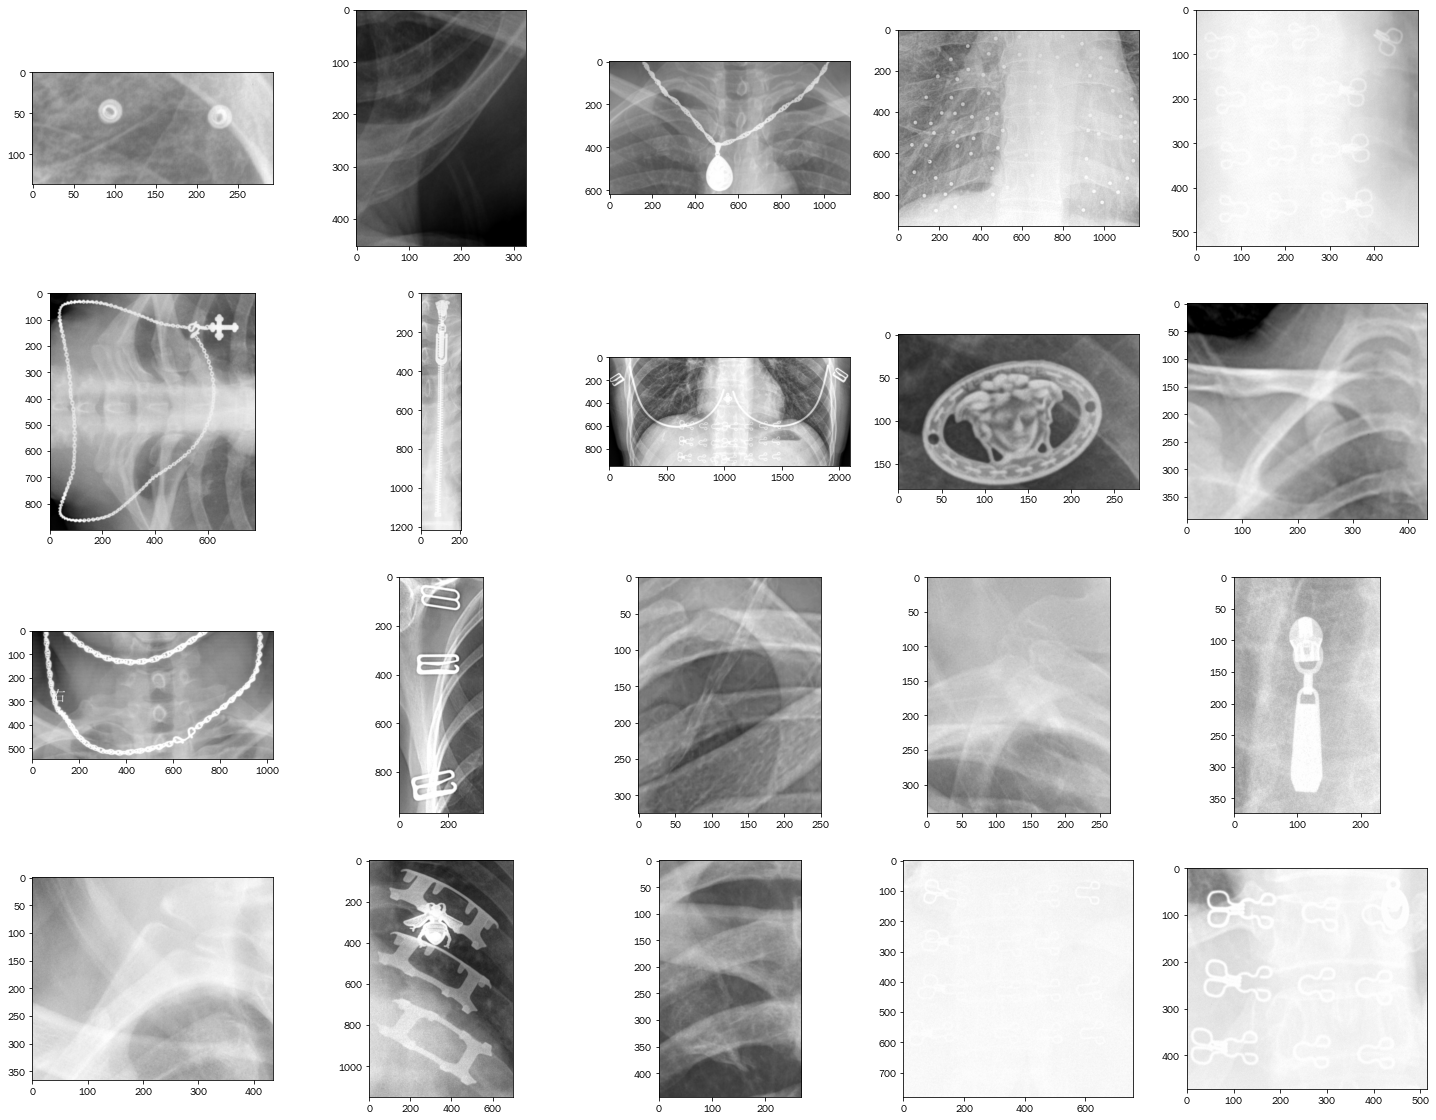

In [17]:
def zoom_class(dataset, classname):
    samples = find_class(dataset, classname, 20)

    f, axarr = plt.subplots(4, 5, figsize=(25, 20)) 
    for i, sample in enumerate(samples):
        
        image = sample['input']
        width, height = image.width, image.height
        scale = np.asarray([width, height, width, height])
        for box in sample['bbox']:
            #box = np.clip(box, 0, 1)
            if dataset.classnames[int(box[-1])] == classname:
                coord = box[:4] * scale
                image = image.crop(coord)
                break
        axarr.flat[i].imshow(image)
    return samples

samples = zoom_class(dataset, 'object')

In [18]:
def zoom_class_all(dataset, classname):
    samples = find_class(dataset, classname, 0)
    if not samples:
        print(f'no {classname} found!')
    rows = int(np.ceil(len(samples) / 5))
    
    f, axarr = plt.subplots(rows, 5, figsize=(25, rows))
    for i, sample in enumerate(samples):
        
        image = sample['input']
        width, height = image.width, image.height
        scale = np.asarray([width, height, width, height])
        for box in sample['bbox']:
            #box = np.clip(box, 0, 1)
            if dataset.classnames[int(box[-1])] == classname:
                coord = box[:4] * scale
                image = image.crop(coord)
                break
        ax = axarr.flat[i]
        ax.imshow(image)
        ax.set_anchor('W')
    f.suptitle(classname, fontsize=32)
    return samples

#samples = zoom_class_all(dataset, 'object')
#plt.show()

#  Statstics

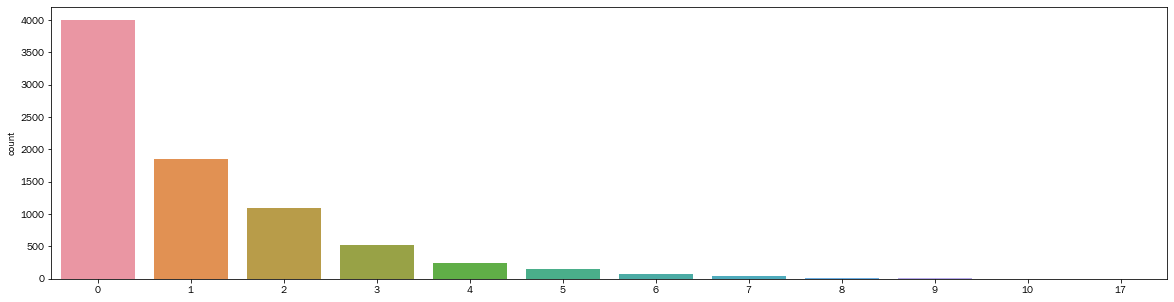

(17, 1.027875, 0, 8000)

In [27]:
def anns_per_img(dataset):
    data = [len(dataset.coco.imgToAnns[i]) for i in dataset.ids]
    plt.figure(figsize=(20,5))
    sns.countplot(data)
    plt.show()
    return max(data), sum(data)/len(data), min(data), len(data)

anns_per_img(dataset)

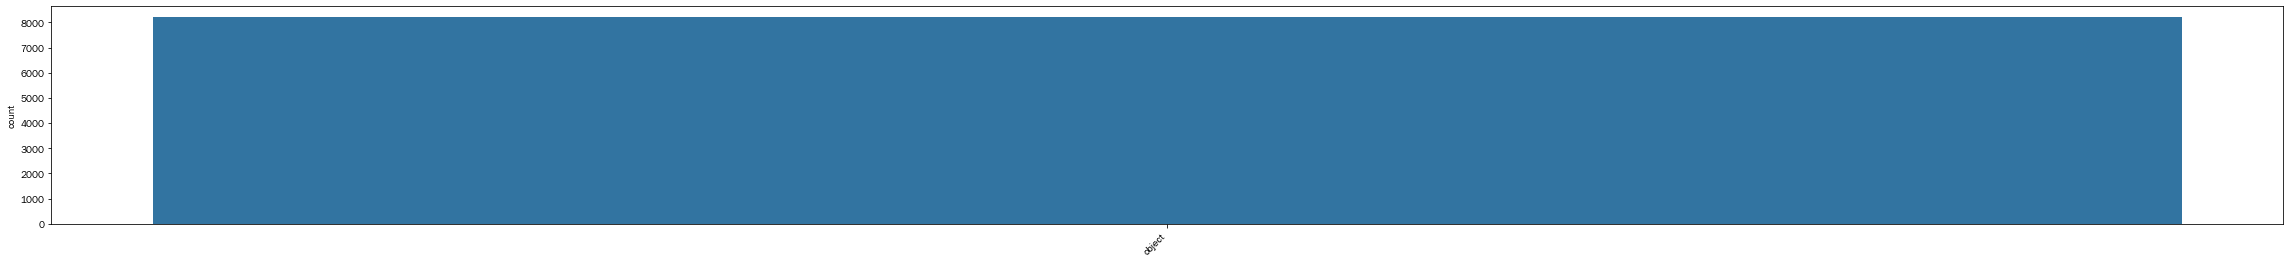

missed_classes 0 []


In [28]:
def category_id(dataset):
    data = []
    for i in dataset.ids:
        anns = dataset.coco.imgToAnns[i]
        data += [a['category_id'] for a in anns]
    names = [dataset.classnames[d] for d in data]
    missed_classes = [c for c in dataset.classnames[1:] if c not in names]
    names = pd.Series(names)
    plt.figure(figsize=(40,4))
    value_counts = names.value_counts()
    ax = sns.countplot(names, order=value_counts.index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.show()
    print('missed_classes', len(missed_classes), missed_classes)
    cls_count = value_counts.to_dict()
    for c in missed_classes:
        cls_count[c] = 0
    return cls_count

cls_count = category_id(dataset)

Text(0.5, 1.0, 'max')

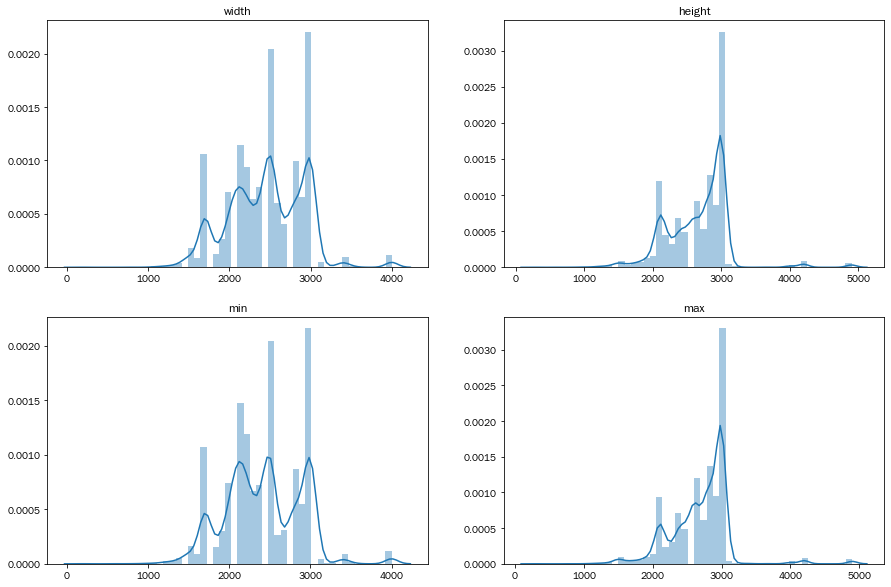

In [40]:
image_sizes = np.asarray([[img['width'], img['height']] for img in dataset.coco.imgs.values()])
image_sizes = image_sizes // 100 * 100
plt.figure(figsize=(15, 10))
plt.subplot(221)
ax = sns.distplot(image_sizes[:, 0])
plt.title('width')
plt.subplot(222)
ax = sns.distplot(image_sizes[:, 1])
plt.title('height')
plt.subplot(223)
ax = sns.distplot(np.minimum(image_sizes[:, 0], image_sizes[:, 1]))
plt.title('min')
plt.subplot(224)
ax = sns.distplot(np.maximum(image_sizes[:, 0], image_sizes[:, 1]))
plt.title('max')

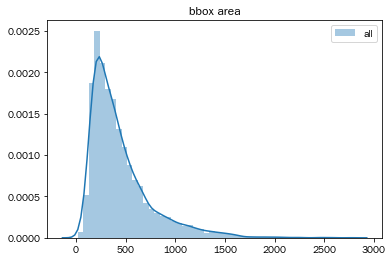

In [32]:
def area(dataset, cls=None):
    data = []
    for i in dataset.ids:
        anns = dataset.coco.imgToAnns[i]
        data += [int(a['area']) for a in anns if cls is None or cls == a['category_id']]
    data = [d for d in data if d > 1]
    label = 'all'
    if cls:
        label = dataset.classnames[cls]
    sns.distplot(np.sqrt(data), label=label)
    plt.title('bbox area')
    plt.legend()
    plt.show()
area(dataset)

## width height ratio

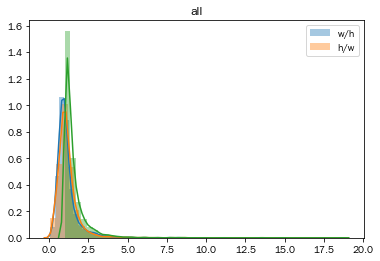

In [33]:
def width_div_height(dataset, cls=None):
    data = []
    for i in dataset.ids:
        anns = dataset.coco.imgToAnns[i]
        if cls is not None:
            anns = [a for a in anns if cls == a['category_id']]
        data += [a['bbox'][2] / a['bbox'][3] for a in anns]

    data = np.asarray(data)
    sns.distplot(data, label='w/h')
    data_inv = 1 / data
    sns.distplot(data_inv, label='h/w')
    data_max = np.vstack((data, data_inv))
    data_max = data_max[data_max>=1]
    sns.distplot(data_max)
    title = 'all'
    if cls:
        title = dataset.classnames[cls]
    plt.title(title)
    plt.legend()
    plt.show()
width_div_height(dataset)

## min(width, height)

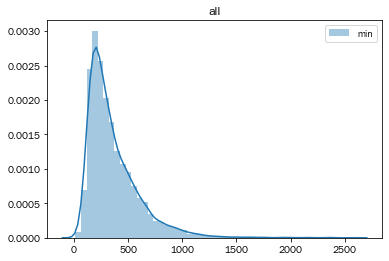

In [34]:
def min_width_height(dataset, cls=None):
    data = []
    for i in dataset.ids:
        anns = dataset.coco.imgToAnns[i]
        if cls is not None:
            anns = [a for a in anns if cls == a['category_id']]
        data += [min(a['bbox'][2], a['bbox'][3]) for a in anns]

    data = np.asarray(data)
    sns.distplot(data, label='min')
    title = 'all'
    if cls:
        title = dataset.classnames[cls]
    plt.title(title)
    plt.legend()
    plt.show()
min_width_height(dataset)